In [ ]:
!pip install python-docx
!pip install albumentations
!pip install pytorch-lightning
!pip install timm
!pip install torchmetrics

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import cv2
import seaborn as sns
from skimage import io


In [ ]:
vietnamese_names_df = pd.read_excel("/kaggle/input/vietnamese-herbarium/Vietnamese_Names.xlsx")
vietnamese_names_df

,Scientific name,Vietnamese name
0,Abutilon indicum (L.) Sweet,Cối Xay
1,Achillea millefolium L.,Cỏ Thi
2,Achyranthes aspera L.,Cỏ Xước
3,Acorus calamus L.,Thủy Xương Bồ
4,Acrostichum aureum L.,Ráng Biển
5,Aeschynomene indica L.,Rút Nước
6,Agave americana L.,Dứa Mỹ
7,Agave sisalana Perrine,Dứa Sợi
8,Ageratum conyzoides L.,Cỏ Cứt Lợn
9,Allamanda cathartica L.,Bông Vàng


# EDA

In [ ]:
TRAIN_DIR = "../input/herbarium-2022-fgvc9/train_images/"

with open("../input/herbarium-2022-fgvc9/train_metadata.json") as json_file:
    train_meta = json.load(json_file)

image_ids = [image["image_id"] for image in train_meta["images"]]
image_dirs = [TRAIN_DIR + image["file_name"] for image in train_meta["images"]]
category_ids = [annot["category_id"] for annot in train_meta["annotations"]]
genus_ids = [annot["genus_id"] for annot in train_meta["annotations"] ]


train = pd.DataFrame(data =np.array([image_ids , image_dirs, genus_ids, category_ids ]).T,
                     columns = ["image_id", "directory","genus_id", "category",])


# Load categories and filter based on Vietnamese names
categories = pd.DataFrame(train_meta["categories"])
categories = categories[categories["scientificName"].isin(vietnamese_names_df["Scientific name"])]

# Ensure the data types of the columns to be merged match
train["category"] = train["category"].astype(int)
categories["category_id"] = categories["category_id"].astype(int)

# Merge the train data with the filtered categories data
train = train.merge(categories, left_on="category", right_on="category_id", how="inner")

# Strip whitespace from scientific names in both dataframes
train["scientificName"] = train["scientificName"].str.strip()
vietnamese_names_df["Scientific name"] = vietnamese_names_df["Scientific name"].str.strip()

# Merge with Vietnamese names
train = train.merge(vietnamese_names_df, left_on="scientificName", right_on="Scientific name", how="inner")

# Replace the scientificName with the Vietnamese name if available
train['scientificName'] = train['Vietnamese name'].combine_first(train['scientificName'])

# Drop unnecessary columns
train = train.drop(columns=['scientificName'])

# Save the updated data to CSV
train.to_csv("train.csv", index=False)


In [ ]:
df_train = pd.read_csv('train.csv')
genera = pd.DataFrame(train_meta['genera'])
genera  = df_train.merge(genera,on='genus_id', how='inner')
df_train.shape

(15335, 11)

In [ ]:
# Count the number of images per scientific name
image_counts = df_train['Vietnamese name'].value_counts()

# Filter the image counts to only include scientific names with at least 50 images
image_counts = image_counts[image_counts >= 50]

# Create a DataFrame from the filtered image counts
image_counts = image_counts.reset_index()
image_counts.columns = ['Vietnamese name', 'imageCount']

# Display the DataFrame
pd.set_option('display.max_rows', None)
print(image_counts)

# Save the DataFrame to a CSV file
image_counts.to_csv('filtered_image_counts_per_Vietnamese_name.csv', index=False)

           Vietnamese name  imageCount
0              Cỏ Mật Nhẵn          77
1        Xà Thiệt Có Cuống          76
2              Hướng Dương          76
3              Bìm Ba Thùy          76
4                  Lức Dây          76
5             Ké Đồng Tiền          76
6                    Đu Đủ          76
7            Rong Đuôi Chó          76
8                 Kim Đồng          75
9                 Bông Vải          75
10               Ngải Thơm          75
11               Đại Trắng          75
12               Khoai Tây          75
13                   Cỏ Mủ          75
14                  Lá Hến          75
15             Lan Cau Tím          75
16                   Cocoa          75
17                Đông Quỳ          75
18                 Đậu Ngự          74
19                     Lạc          74
20                     Dệu          74
21                     Sắn          74
22              Tra Lâm Vồ          74
23           Thủy Xương Bồ          74
24            Trạng Nguyê

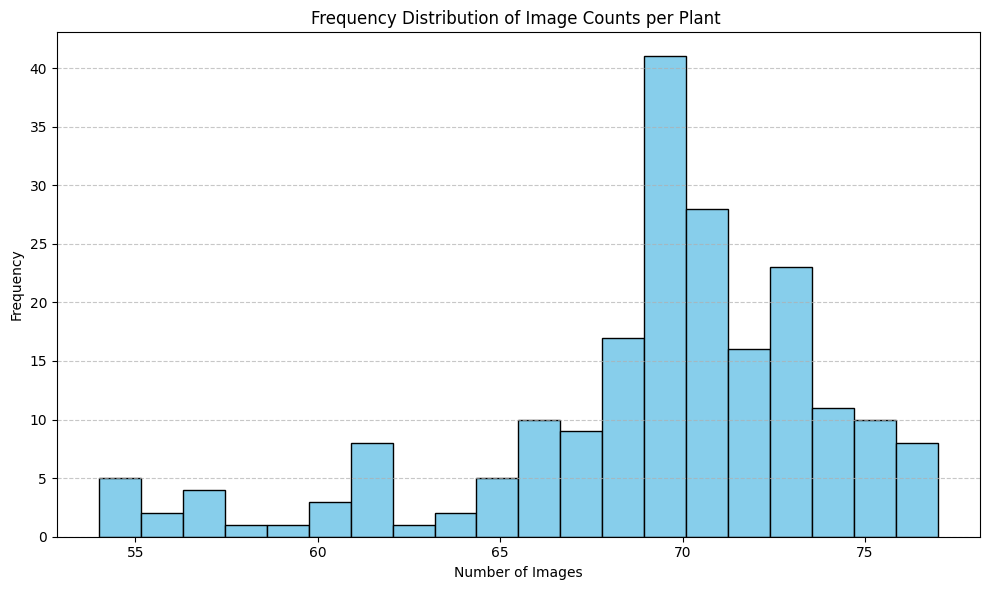

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(image_counts['imageCount'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Image Counts per Plant ')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Filter df_train to only include rows with scientific names that have at least 50 images
df_train = df_train[df_train['Vietnamese name'].isin(image_counts['Vietnamese name'])]

# Save the filtered train data to CSV
df_train.to_csv('filtered_train.csv', index=False)



# Sample Images

In [ ]:
from PIL import Image
def display_images(VietName):
    images = df_train.loc[df_train['Vietnamese name'] == VietName]['directory'][:12]
    i = 1
    fig = plt.figure(figsize = (10, 10))
    plt.suptitle(VietName, fontsize = '35')
    for image in images:
        ax = fig.add_subplot(3, 4, i)
        image = Image.open(image).convert('RGB')
        ax.imshow(image)
        i+=1
    fig.tight_layout()
    plt.show()

display_images('Cối Xay')

In [ ]:
# Display random images with names
def display_random_images(df, num_images=12):
    plt.figure(figsize=(10, 10))
    sample = df.sample(num_images)
    for i, (index, row) in enumerate(sample.iterrows()):
        plt.subplot(3, 4, i + 1)
        img = Image.open(row['directory']).convert('RGB')
        plt.imshow(img)
        plt.title(row['Vietnamese name'])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to display images
display_random_images(df_train)

# Encode Class Labels

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df_train['category'])
df_train['category'] = le.transform(df_train['category'])
df_train.category.nunique()

205

In [ ]:
df_train.head()

,image_id,directory,genus_id,category,category_id,family,genus,species,authors,Scientific name,Vietnamese name
0,00033__001,../input/herbarium-2022-fgvc9/train_images/000...,4,0,33,Malvaceae,Abutilon,indicum,(L.) Sweet,Abutilon indicum (L.) Sweet,Cối Xay
1,00033__002,../input/herbarium-2022-fgvc9/train_images/000...,4,0,33,Malvaceae,Abutilon,indicum,(L.) Sweet,Abutilon indicum (L.) Sweet,Cối Xay
2,00033__003,../input/herbarium-2022-fgvc9/train_images/000...,4,0,33,Malvaceae,Abutilon,indicum,(L.) Sweet,Abutilon indicum (L.) Sweet,Cối Xay
3,00033__004,../input/herbarium-2022-fgvc9/train_images/000...,4,0,33,Malvaceae,Abutilon,indicum,(L.) Sweet,Abutilon indicum (L.) Sweet,Cối Xay
4,00033__006,../input/herbarium-2022-fgvc9/train_images/000...,4,0,33,Malvaceae,Abutilon,indicum,(L.) Sweet,Abutilon indicum (L.) Sweet,Cối Xay


# Config

In [ ]:
import timm
import torch
import torch.nn as nn
import torch.functional as F
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset,DataLoader

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics


import albumentations as A
from albumentations.core.composition import Compose
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
%matplotlib inline

In [ ]:
class CFG:
    seed = 42
    model_name = 'tf_efficientnetv2_m_in21k'
    pretrained = True
    img_size = 384
    num_classes = df_train.category.nunique()
    lr = 5e-4
    min_lr = 1e-6
    t_max = 20
    num_epochs = 50
    batch_size = 32
    accum = 1
    precision = 16
    dropout_rate = 0.3


In [ ]:
seed_everything(CFG.seed)


42

In [ ]:
df_train.head()


,image_id,directory,genus_id,category,category_id,family,genus,species,authors,Scientific name,Vietnamese name
0,00033__001,../input/herbarium-2022-fgvc9/train_images/000...,4,0,33,Malvaceae,Abutilon,indicum,(L.) Sweet,Abutilon indicum (L.) Sweet,Cối Xay
1,00033__002,../input/herbarium-2022-fgvc9/train_images/000...,4,0,33,Malvaceae,Abutilon,indicum,(L.) Sweet,Abutilon indicum (L.) Sweet,Cối Xay
2,00033__003,../input/herbarium-2022-fgvc9/train_images/000...,4,0,33,Malvaceae,Abutilon,indicum,(L.) Sweet,Abutilon indicum (L.) Sweet,Cối Xay
3,00033__004,../input/herbarium-2022-fgvc9/train_images/000...,4,0,33,Malvaceae,Abutilon,indicum,(L.) Sweet,Abutilon indicum (L.) Sweet,Cối Xay
4,00033__006,../input/herbarium-2022-fgvc9/train_images/000...,4,0,33,Malvaceae,Abutilon,indicum,(L.) Sweet,Abutilon indicum (L.) Sweet,Cối Xay


# Custom Dataset

In [ ]:
class VietNamHerbariumDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data.iloc[index, 1]
        image = io.imread(img_path)
        label = torch.tensor(int(self.data.iloc[index, 3]))

        if self.transform:
            image = self.transform(image=image)['image']

        return {'image': image}, label

# Image Augmentation

In [ ]:
def Transform(phase: str):
    if phase == 'train':
        return A.Compose([
            A.RandomResizedCrop(height=CFG.img_size, width=CFG.img_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2,
                sat_shift_limit=0.2,
                val_shift_limit=0.2,
                p=0.5),
            A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=CFG.img_size, width=CFG.img_size),
            A.CenterCrop(384, 384),  # Consistent center crop
            A.Normalize(),
            ToTensorV2(),
        ])

# Create Dataloader

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
train_data, temp_data = train_test_split(df_train, test_size=0.3, random_state=CFG.seed, stratify=df_train['category'])
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=CFG.seed, stratify=temp_data['category'])

# Verify the splits
print(f"Training data shape: {train_data.shape}")
print(f"Valid data shape: {valid_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (9923, 11)
Valid data shape: (2127, 11)
Test data shape: (2127, 11)


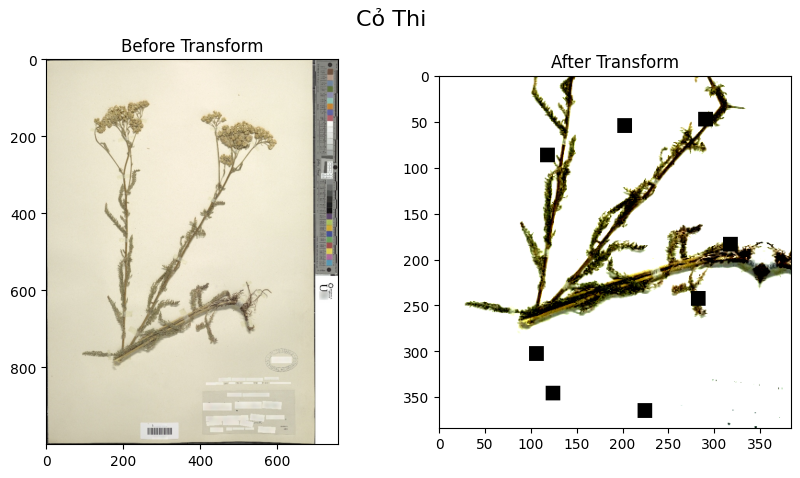

In [ ]:
def display_before_after_transforms(df, transform, index):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Get the image path and plant name from the dataframe
    img_path = df.iloc[index, 1]
    plant_name = df.iloc[index, df.columns.get_loc('Vietnamese name')]

    # Load and display the original image
    original_image = Image.open(img_path).convert('RGB')
    ax[0].imshow(original_image)
    ax[0].set_title('Before Transform')

    # Apply the transformation and display the transformed image
    image = io.imread(img_path)
    transformed = transform(image=image)
    transformed_image = transformed['image'].permute(1, 2, 0).numpy()
    ax[1].imshow(transformed_image)
    ax[1].set_title('After Transform')

    # Display the plant name
    plt.suptitle(plant_name, fontsize=16)
    plt.show()

# Example usage of display function
# Assuming df_train is a DataFrame with the second column as image paths and a column named 'Vietnamese name' for plant names
display_before_after_transforms(df_train, Transform('train'), 100)

In [ ]:
train_dataset = VietNamHerbariumDataset(train_data,transform=Transform('train'))
valid_dataset = VietNamHerbariumDataset(valid_data,transform=Transform('valid'))

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2)

# Transformed Image

torch.Size([3, 384, 384])
torch.Size([])


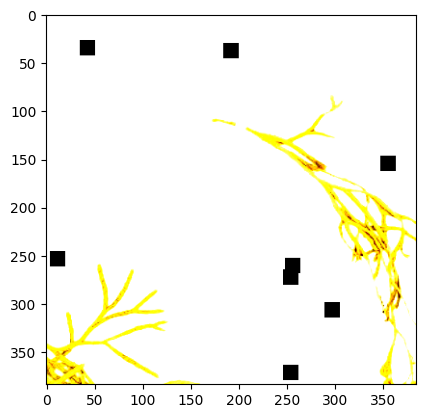

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images['image'][1].shape)
print(labels[1].shape)
plt.imshow(images['image'][3].squeeze().permute(1,2,0), cmap='Greys_r')

# Model

In [ ]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name='tf_efficientnetv2_m_in21k', pretrained=True, fine_tune=False,dropout_rate=0.2):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.get_classifier().in_features

        # Adjust the classifier to the number of classes in your dataset
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, CFG.num_classes)
        )

        # Freeze first 100 layers
        if fine_tune:
            for idx, param in enumerate(self.model.parameters()):
                if idx < 100:
                    param.requires_grad = False

    def forward(self, x):
        x = self.model(x)
        return x


In [ ]:
class LitHerbarium(pl.LightningModule):
    def __init__(self, model):
        super(LitHerbarium, self).__init__()
        self.model = model
        self.metric = torchmetrics.F1Score(num_classes=CFG.num_classes, task='multiclass') # F1 Score
        self.criterion = nn.CrossEntropyLoss() # Cross Entropy loss
        self.lr = CFG.lr # Learning Rate

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def configure_optimizers(self):
        """Choose what optimizers and learning-rate schedulers to use in your optimization"""
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=CFG.t_max, eta_min=CFG.min_lr)

        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}

    def training_step(self, batch, batch_idx):
        """Here you compute and return the training loss and some additional metrics for e.g. the progress bar or logger"""
        image,target = batch
        image = image['image']
        output = self.model(image)
        loss = self.criterion(output, target)
        score = self.metric(output.argmax(1), target)
        logs = {'train_loss': loss, 'train_f1': score, 'lr': self.optimizer.param_groups[0]['lr']}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        """Operates on a single batch of data from the validation set .calculate anything of interest like accuracy."""
        image,target = batch
        image = image['image']
        output = self.model(image)
        loss = self.criterion(output, target)
        score = self.metric(output.argmax(1), target)
        logs = {'valid_loss': loss, 'valid_f1': score}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss



In [ ]:
model = CustomEfficientNet(model_name=CFG.model_name, pretrained=CFG.pretrained, fine_tune=True, dropout_rate=CFG.dropout_rate)
lit_model = LitHerbarium(model)
lit_model

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnetv2_m_in21k to current tf_efficientnetv2_m.in21k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/325M [00:00<?, ?B/s]

LitHerbarium(
  (model): CustomEfficientNet(
    (model): EfficientNet(
      (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): ConvBnAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNormAct2d(
              24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (drop_path): Identity()
          )
          (1): ConvBnAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNormAct2d(
              24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
   

# Trainer

In [ ]:
logger = CSVLogger(save_dir='logs/', name=CFG.model_name)
logger.log_hyperparams(CFG.__dict__)
checkpoint_callback = ModelCheckpoint(monitor='valid_loss',
                                      save_top_k=1,
                                      save_last=True,
                                      save_weights_only=True,
                                      filename='checkpoint/{epoch:02d}-{valid_loss:.4f}-{valid_f1:.4f}',
                                      verbose=False,
                                      mode='min')

# Initialize early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='valid_loss',
    patience=3,
    mode='min'
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=CFG.num_epochs,
    devices=1,
    accelerator='gpu',
    accumulate_grad_batches=CFG.accum,
    precision=CFG.precision,
    callbacks=[checkpoint_callback, early_stopping_callback],
    enable_checkpointing=True,
    logger=logger,
)

/opt/conda/lib/python3.10/site-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!


In [ ]:
trainer.fit(lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:356: Skipping '__dict__' parameter because it is not possible to safely dump to YAML.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:356: Skipping '__weakref__' parameter because it is not possible to safely dump to YAML.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
torch.save(lit_model,'best_model.pth')


# Plot Metrics

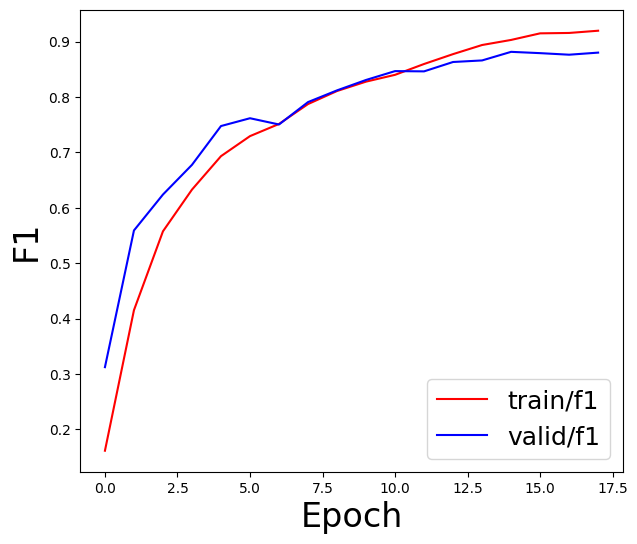

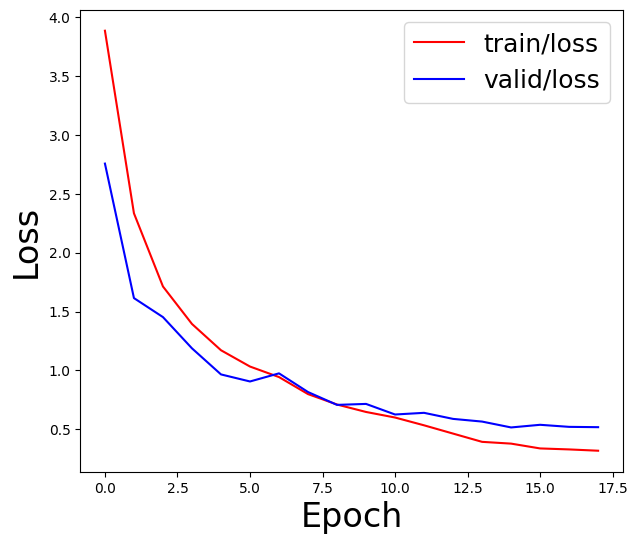

In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_acc = metrics['train_f1'].dropna().reset_index(drop=True)
valid_acc = metrics['valid_f1'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))

plt.plot(train_acc, color="r", label='train/f1')
plt.plot(valid_acc, color="b", label='valid/f1')
plt.ylabel('F1', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='lower right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/f1.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.plot(train_loss, color="r", label='train/loss')
plt.plot(valid_loss, color="b", label='valid/loss')
plt.ylabel('Loss', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/loss.png')

# Inference



In [ ]:
# Set device for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class VietNamHerbariumTestDataset(Dataset):
    def __init__(self, data, transform=None):
        self.annotations = data
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 1]
        image = io.imread(img_path)

        if self.transform:
            image = self.transform(image=np.array(image))

        return image

In [ ]:
# Load the trained model
model = torch.load('/kaggle/input/bestweight/best_model.pth')
model.eval()

# Define the transformation for inference
def inference_transform():
    return A.Compose([
        A.OneOf([
            A.Resize(400, 400),
            A.Resize(416, 416),
            A.Resize(448, 448),
            A.Resize(480, 480),
            A.Resize(512, 512),
        ], p=1),
        A.CenterCrop(384, 384),
        A.Normalize(),
        ToTensorV2(),
    ])

# Function to perform inference on the test dataset
def predict_test(model, test_loader):
    model.eval()
    predictions = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    with torch.no_grad():
        for images in test_loader:
            images = images['image'].to(device)  # Send images to the same device as the model
            outputs = model(images)
            predicted_classes = torch.argmax(outputs, dim=1)
            predictions.extend(predicted_classes.cpu().numpy())
    return predictions

In [ ]:
# Create Test Dataloader
test_dataset = VietNamHerbariumTestDataset(test_data, transform=inference_transform())
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2)


In [ ]:
# Load the trained model
model = torch.load('/kaggle/input/bestweight/best_model.pth')
model.eval()

LitHerbarium(
  (model): CustomEfficientNet(
    (model): EfficientNet(
      (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): ConvBnAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNormAct2d(
              24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (drop_path): Identity()
          )
          (1): ConvBnAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNormAct2d(
              24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
   

In [ ]:
import time

# Perform inference on the test dataset and measure the time taken
start_time = time.time()
predictions = predict_test(model, test_loader)
end_time = time.time()

# Calculate the total prediction time
total_prediction_time = end_time - start_time

# Save the predictions to a CSV file
test_data['predicted_category'] = predictions
test_data.to_csv('test_predictions.csv', index=False)

print("Predictions saved to test_predictions.csv")
print(f"Total prediction time: {total_prediction_time:.2f} seconds")
print(f"Average prediction time per image: {total_prediction_time / len(test_data):.4f} seconds")


Predictions saved to test_predictions.csv
Total prediction time: 22.35 seconds
Average prediction time per image: 0.0105 seconds


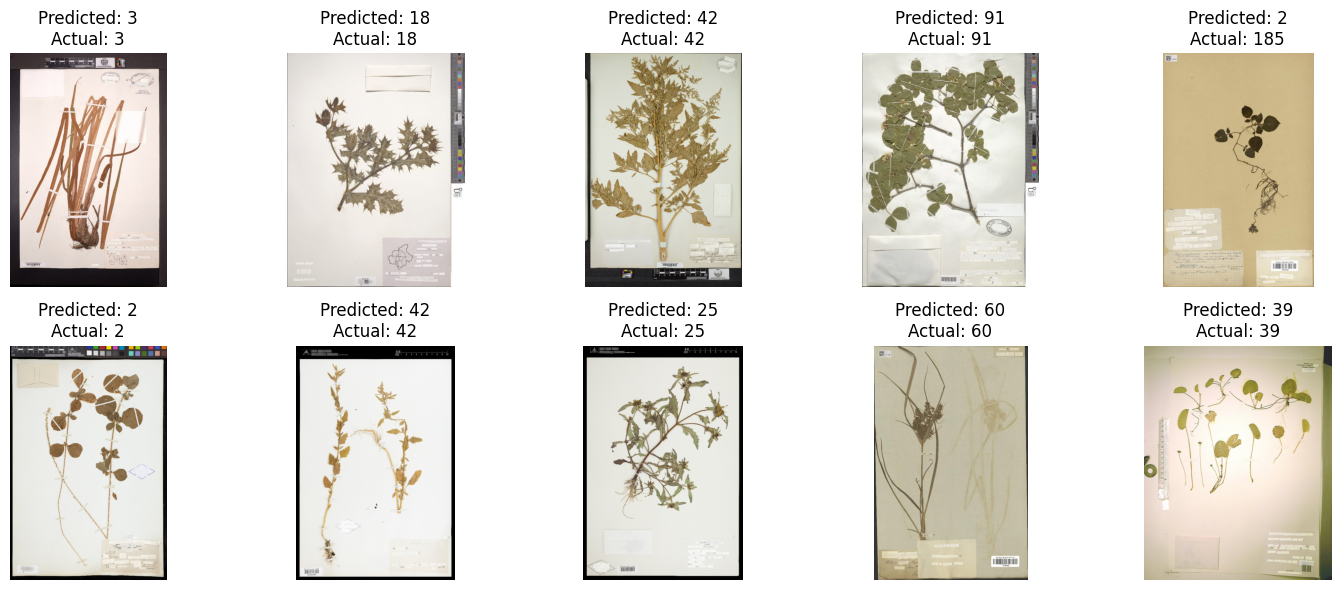

In [ ]:
# Plot the first 10 images along with their predicted categories
plt.figure(figsize=(15, 6))
for i in range(10):
    image_path = test_data.iloc[i]['directory']  # Assuming 'directory' contains the file path of images
    predicted_category = test_data.iloc[i]['predicted_category']
    actual_category = test_data.iloc[i]['category']

    # Load and plot the image
    image = plt.imread(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_category}\nActual: {actual_category}')


plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/kaggle/working/test_predictions.csv')

# Tính độ chính xác
accuracy = (data['category'] == data['predicted_category']).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 90.64%


In [ ]:
test_data.head()

,image_id,directory,genus_id,category,category_id,family,genus,species,authors,Scientific name,Vietnamese name,predicted_category
213,00130__016,../input/herbarium-2022-fgvc9/train_images/001...,30,3,130,Acoraceae,Acorus,calamus,L.,Acorus calamus L.,Thủy Xương Bồ,3
1417,01040__025,../input/herbarium-2022-fgvc9/train_images/010...,188,18,1040,Papaveraceae,Argemone,mexicana,L.,Argemone mexicana L.,Gai Cua,18
3178,03392__120,../input/herbarium-2022-fgvc9/train_images/033...,510,42,3392,Amaranthaceae,Chenopodium,album,L.,Chenopodium album L.,Rau Muối,42
6953,06885__060,../input/herbarium-2022-fgvc9/train_images/068...,1075,91,6885,Zygophyllaceae,Guaiacum,officinale,L.,Guaiacum officinale L.,Dũ Sang,91
13686,13758__019,../input/herbarium-2022-fgvc9/train_images/137...,2234,185,13758,Solanaceae,Solanum,tuberosum,L.,Solanum tuberosum L.,Khoai Tây,2


In [ ]:
accuracy_per_class = test_data.groupby('category').apply(
    lambda x: (x['category'] == x['predicted_category']).sum() / len(x) * 100
).reset_index(name='accuracy')

# Extract unique category and Vietnamese name pairs
category_vietnamese_name = test_data[['category', 'Vietnamese name']].drop_duplicates()

# Merge the accuracy with the Vietnamese name
accuracy_per_class = pd.merge(accuracy_per_class, category_vietnamese_name, on='category')

# Reorder columns to have accuracy after Vietnamese name
accuracy_per_class = accuracy_per_class[['Vietnamese name', 'accuracy']]
accuracy_per_class.to_csv('accuracy_per_class.csv', index=False)

# Display the result
print(accuracy_per_class)


           Vietnamese name    accuracy
0                  Cối Xay   70.000000
1                   Cỏ Thi  100.000000
2                  Cỏ Xước   70.000000
3            Thủy Xương Bồ  100.000000
4                Ráng Biển   88.888889
5                 Rút Nước  100.000000
6               Cỏ Cứt Lợn   90.909091
7                Bông Vàng  100.000000
8                 Hành Tăm  100.000000
9                 Dệu Cảnh   66.666667
10                     Dệu   81.818182
11           Dền Đuôi Chồn   90.000000
12                 Dền Gai  100.000000
13                 Dền Cơm   90.909091
14             Đào Lộn Hột   80.000000
15           Mãng Cầu Xiêm  100.000000
16                      Na   90.000000
17                     Lạc  100.000000
18                 Gai Cua  100.000000
19           Ngải Hoa Vàng  100.000000
20               Ngải Thơm   91.666667
21                Ngải Cứu   90.000000
22           Rau Đắng Biển   72.727273
23    Song Nha Hai Lần Kép   90.909091
24                 Đơn Ki

/tmp/ipykernel_34/3744790022.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_class = test_data.groupby('category').apply(
